In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
df = pd.read_csv('./data/nbaallelo.csv')

# shuffle dataframe
df = df.sample(frac=1).reset_index(drop = True)

# drop duplicate game ids
df.drop_duplicates(subset = 'game_id', keep = 'first', inplace = True)

df.drop(['_iscopy', 'team_id', 'opp_id' , 'notes', 'elo_n', 'opp_elo_n'], axis = 1, inplace = True)
df.game_location.replace({'H': 1, 'A': 0, 'N': 0}, inplace = True)

df['elo_diff'] = df.elo_i - df.opp_elo_i
df.head()

,gameorder,game_id,lg_id,year_id,date_game,seasongame,is_playoffs,fran_id,pts,elo_i,win_equiv,opp_fran,opp_pts,opp_elo_i,game_location,game_result,forecast,elo_diff
0,31406,199001110SEA,NBA,1990,1/11/1990,34,0,Mavericks,87,1444.3356,36.926449,Thunder,98,1506.8972,0,L,0.281754,-62.5616
1,3132,195501130BOS,NBA,1955,1/13/1955,35,0,Knicks,100,1484.4932,35.162704,Celtics,116,1578.5471,0,L,0.246556,-94.0539
2,43900,200011020NYK,NBA,2001,11/2/2000,2,0,Hawks,69,1354.0496,25.816339,Knicks,94,1525.9358,0,L,0.172916,-171.8862
3,13202,197204060NYK,NBA,1972,4/6/1972,86,1,Knicks,104,1472.7321,43.138966,Wizards,98,1433.1967,1,W,0.690665,39.5354
4,13756,197212290HOU,NBA,1973,12/29/1972,38,0,Bucks,114,1669.8235,61.108528,Rockets,101,1483.0968,0,W,0.622280,186.7267


In [111]:
print(df.shape)
print(df.info())

(63157, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63157 entries, 0 to 125914
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gameorder      63157 non-null  int64  
 1   game_id        63157 non-null  object 
 2   lg_id          63157 non-null  object 
 3   year_id        63157 non-null  int64  
 4   date_game      63157 non-null  object 
 5   seasongame     63157 non-null  int64  
 6   is_playoffs    63157 non-null  int64  
 7   fran_id        63157 non-null  object 
 8   pts            63157 non-null  int64  
 9   elo_i          63157 non-null  float64
 10  win_equiv      63157 non-null  float64
 11  opp_fran       63157 non-null  object 
 12  opp_pts        63157 non-null  int64  
 13  opp_elo_i      63157 non-null  float64
 14  game_location  63157 non-null  int64  
 15  game_result    63157 non-null  object 
 16  forecast       63157 non-null  float64
dtypes: float64(4), int64(7), object(6)
me

In [117]:
group = df.groupby('game_result').aggregate({'elo_i': np.average, 'opp_elo_i': np.average, 
                                             'game_location': np.average, 'game_id': 'count',
                                             'elo_diff': np.average}).rename(columns = {'game_id': 'count'})
group

,elo_i,opp_elo_i,game_location,count,elo_diff
game_result,,,,,
L,1468.991225,1520.929257,0.376093,31572,-51.938032
W,1521.922525,1469.100988,0.621054,31585,52.821537


### Perm Test

In [102]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

### Elo Diffs

In [105]:
actual_diff = group.loc['W'].elo_diff
diffs = [perm_fun(df, 'elo_i', group.loc['W', 'count']) for _ in range(1000)]

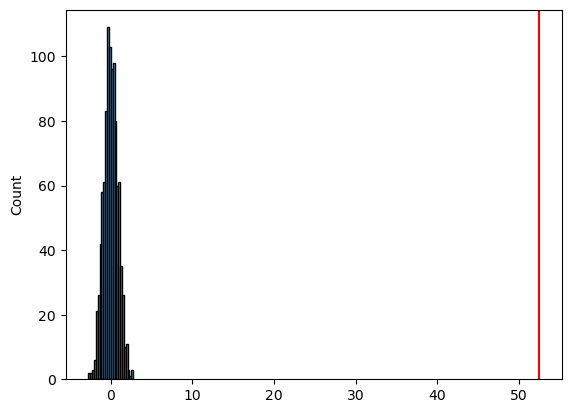

In [106]:
sns.histplot(diffs)
plt.axvline(actual_diff, color = 'red')
plt.show()

### Home Diffs

In [107]:
actual_diff = group.loc['W', 'game_location'] - group.loc['L', 'game_location']
diffs = [perm_fun(df, 'game_location', group.loc['W', 'count']) for _ in range(1000)]

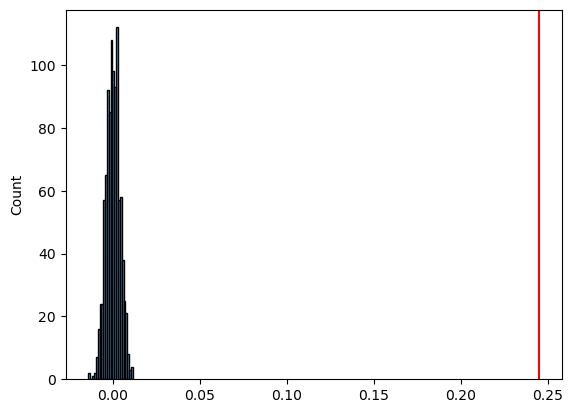

In [108]:
sns.histplot(diffs)
plt.axvline(actual_diff, color = 'red')
plt.show()

<AxesSubplot:>

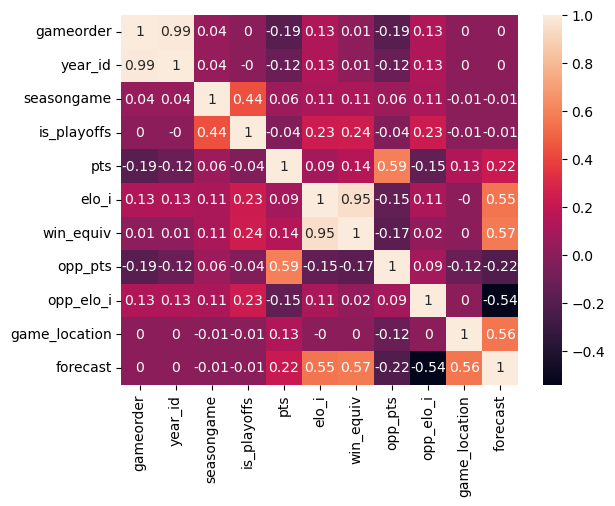

In [109]:
sns.heatmap(df.corr().round(2), annot = True)

## Modeling

#### Normalize Features

In [123]:
model_df = df[['elo_diff', 'game_location', 'game_result']].copy()

mu = model_df.elo_diff.mean()
std = model_df.elo_diff.std()


model_df.elo_diff = (model_df.elo_diff - mu) / std
model_df.game_result.replace({'W': 1, 'L': 0}, inplace = True)
model_df

,elo_diff,game_location,game_result
0,-0.420110,0,0
1,-0.630067,0,0
2,-1.148968,0,0
3,0.260562,1,1
4,1.241875,0,1
...,...,...,...
125279,-0.595491,1,1
125292,0.544716,1,1
125369,-0.163696,1,0
125544,-1.821622,1,0


In [125]:
def forward_prop(w, b, x):
    a = np.dot(w, x) + b
    
    return a

In [ ]:
def backward_prop(w, b, w, y):